In [1]:
import pandas as pd
import numpy as np

df_Model = pd.read_csv("../Data Model/EU_Model.csv")
smaller_df = pd.read_csv("../Clean Data/Spread_Cleaned_EU.csv")
df_Model.info()
smaller_df.info()

<ipython-input-1-f9577fe09d82>:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146 entries, 0 to 1145
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                1146 non-null   object 
 1   PX_LAST             1146 non-null   float64
 2   GARCH_Volatility    1146 non-null   float64
 3   Sigma_Annualized    1146 non-null   float64
 4   VSTOXX              1146 non-null   float64
 5   EURIBOR3M           1146 non-null   float64
 6   Daily_STIR          1146 non-null   float64
 7   Theoretical_Spread  1146 non-null   float64
dtypes: float64(7), object(1)
memory usage: 67.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197 entries, 0 to 196
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Date         197 non-null    object 
 1   PX_LAST      197 non-null    float64
 2   PX_VOLUME_x  197 non-null    float64
 3   VSTOXX       197 non-null    flo

In [23]:
import pandas as pd
import numpy as np

df_Model['Date'] = pd.to_datetime(df_Model['Date'])
smaller_df['Date'] = pd.to_datetime(smaller_df['Date'])
joined_df = pd.merge(df_Model, smaller_df, on='Date', suffixes=('', '_smaller'))
joined_df = joined_df.drop(columns=['PX_LAST_smaller', 'PX_VOLUME_x', 'PX_VOLUME_y', 'VSTOXX_smaller', 'EURIBOR3M_smaller'])

initial_investment = 1000
joined_df['CFD_Ask'] = joined_df['PX_LAST'] + (joined_df['Theoretical_Spread'] / 2)
joined_df['CFD_Bid'] = joined_df['PX_LAST'] - (joined_df['Theoretical_Spread'] / 2)

# Leverage limits
upper_leverage = 20  # upper leverage limit as per ESMA
lower_leverage = 5   # lower leverage limit assumed

# Calculate CFD units for upper and lower leverage on the first day (initial CFD units)
joined_df['CFD_Units_Upper'] = (initial_investment * upper_leverage) / joined_df['CFD_Ask'].iloc[0]
joined_df['CFD_Units_Lower'] = (initial_investment * lower_leverage) / joined_df['CFD_Ask'].iloc[0]

# Calculate price delta
joined_df['Price_Delta_Upper'] = joined_df['CFD_Units_Upper'] * (joined_df['CFD_Bid'] - joined_df['CFD_Bid'].shift(1)).fillna(0)
joined_df['Price_Delta_Lower'] = joined_df['CFD_Units_Lower'] * (joined_df['CFD_Bid'] - joined_df['CFD_Bid'].shift(1)).fillna(0)

# Calculate cost of carry based on leverage levels
joined_df['Cost_of_Carry_Upper'] = initial_investment * (upper_leverage - 1) * joined_df['Daily_STIR']
joined_df['Cost_of_Carry_Lower'] = initial_investment * (lower_leverage - 1) * joined_df['Daily_STIR']
joined_df.loc[0, 'Cost_of_Carry_Upper'] = 0
joined_df.loc[0, 'Cost_of_Carry_Lower'] = 0

# Calculate cumulative cost of carry
joined_df['Cumulative_Cost_Upper'] = joined_df['Cost_of_Carry_Upper'].cumsum()
joined_df['Cumulative_Cost_Lower'] = joined_df['Cost_of_Carry_Lower'].cumsum()
joined_df.loc[0, 'Cumulative_Cost_Upper'] = 0
joined_df.loc[0, 'Cumulative_Cost_Lower'] = 0

# Calculate portfolio values
joined_df['Portfolio_Value_Upper'] = initial_investment + joined_df['Price_Delta_Upper'].cumsum() - joined_df['Cumulative_Cost_Upper']
joined_df['Portfolio_Value_Lower'] = initial_investment + joined_df['Price_Delta_Lower'].cumsum() - joined_df['Cumulative_Cost_Lower']

result_df = joined_df[['Date', 'PX_LAST', 'GARCH_Volatility', 'Sigma_Annualized', 'VSTOXX', 
                       'EURIBOR3M', 'Daily_STIR', 'CFD_Ask', 'CFD_Bid', 
                       'Portfolio_Value_Upper', 'Portfolio_Value_Lower', 'Cumulative_Cost_Upper', 'Cumulative_Cost_Lower']]

result_df.to_csv("Portfolio_Value_EU.csv", index=False)
result_df.head()

,Date,PX_LAST,GARCH_Volatility,Sigma_Annualized,VSTOXX,EURIBOR3M,Daily_STIR,CFD_Ask,CFD_Bid,Portfolio_Value_Upper,Portfolio_Value_Lower,Cumulative_Cost_Upper,Cumulative_Cost_Lower
0,2023-12-18,4521.13,0.007258,0.115222,0.129116,0.03938,0.000156,4521.542346,4520.717654,1000.000000,1000.000000,0.000000,0.000000
1,2023-12-19,4535.40,0.007771,0.123362,0.128278,0.03705,0.000147,4535.842871,4534.957129,1060.191584,1015.158164,2.793452,0.588095
2,2023-12-20,4533.82,0.007553,0.119895,0.127353,0.03685,0.000146,4534.250274,4533.389726,1050.480161,1012.839981,5.571825,1.173016
3,2023-12-21,4524.86,0.007337,0.116472,0.135946,0.03680,0.000146,4525.277162,4524.442838,1008.131064,1002.362230,8.346429,1.757143
4,2023-12-22,4521.47,0.007270,0.115406,0.135645,0.03655,0.000145,4521.883036,4521.056964,990.398675,998.037913,11.102183,2.337302


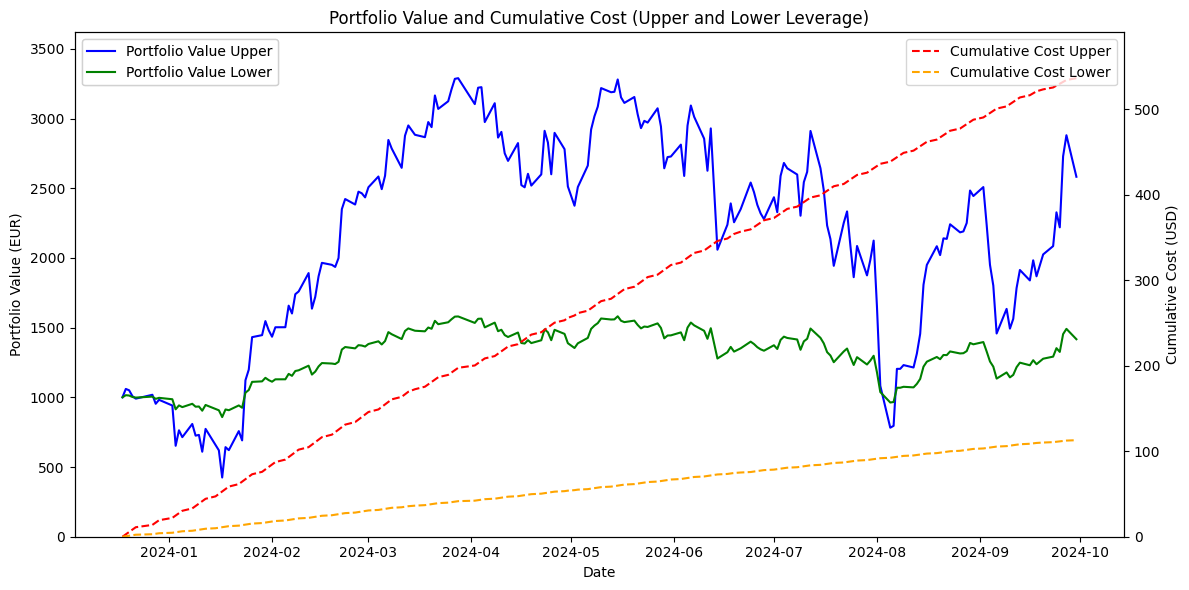

In [22]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_title("Portfolio Value and Cumulative Cost (Upper and Lower Leverage)")
ax1.plot(result_df['Date'], result_df['Portfolio_Value_Upper'], color='b', label='Portfolio Value Upper', linewidth=1.5)
ax1.plot(result_df['Date'], result_df['Portfolio_Value_Lower'], color='g', label='Portfolio Value Lower', linewidth=1.5)
ax1.set_xlabel("Date")
ax1.set_ylabel("Portfolio Value (EUR)")
ax1.set_ylim(0, max(result_df[['Portfolio_Value_Upper', 'Portfolio_Value_Lower']].max()) * 1.1) 

portfolio_legend = ax1.legend(loc="upper left")
ax1.add_artist(portfolio_legend)

ax2 = ax1.twinx()
ax2.plot(result_df['Date'], result_df['Cumulative_Cost_Upper'], color='r', label='Cumulative Cost Upper', linestyle='--', linewidth=1.5)
ax2.plot(result_df['Date'], result_df['Cumulative_Cost_Lower'], color='orange', label='Cumulative Cost Lower', linestyle='--', linewidth=1.5)
ax2.set_ylabel("Cumulative Cost (USD)")
ax2.set_ylim(0, max(result_df[['Cumulative_Cost_Upper', 'Cumulative_Cost_Lower']].max()) * 1.1)

cumulative_cost_legend = ax2.legend(loc="upper right")

fig.tight_layout()
plt.show()